# 데이터 탐색 (시계열 데이터)

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

paths = './data/market-price.csv'
data = pd.read_csv(paths, names=['day', 'price'])

display(data.head())
display(data.info())

,day,price
0,2017-08-27 00:00:00,4354.308333
1,2017-08-28 00:00:00,4391.673517
2,2017-08-29 00:00:00,4607.985450
3,2017-08-30 00:00:00,4594.987850
4,2017-08-31 00:00:00,4748.255000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     365 non-null    object 
 1   price   365 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


None

<AxesSubplot:xlabel='day'>

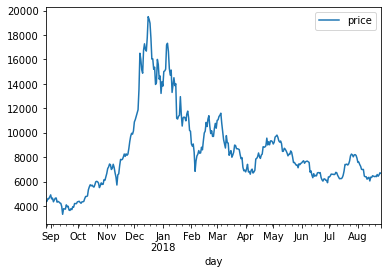

In [16]:
data['day'] = pd.to_datetime(data['day'])
data.set_index('day', inplace=True)

data.plot()

# 예측: ARIMA 활용

    - AR(자기 회귀) : 자기 자신의 과거를 정보로 사용하는 개념 ('현재의 상태는 이전의 상태를 참고해서 계산된다')
    - MA(이동 평균) : '이전 항에서의 오차를 이용하여 현재 항의 상태를 추론 하겠다'
    - ARIMA : 모델에 추세 변동의 경향성 까지 반영한 방법

numpy.float64

In [74]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# (AR=2, 차분=1, MA=2)
model = ARIMA(data['price'].values, order=(2, 1, 2))
model_fit = model.fit()
print(model_fit.summary())

ValueError: In models with integration (`d > 0`) or seasonal integration (`D > 0`), trend terms of lower order than `d + D` cannot be (as they would be eliminated due to the differencing operation). For example, a constant cannot be included in an ARIMA(1, 1, 1) model, but including a linear trend, which would have the same effect as fitting a constant to the differenced data, is allowed.

<AxesSubplot:>

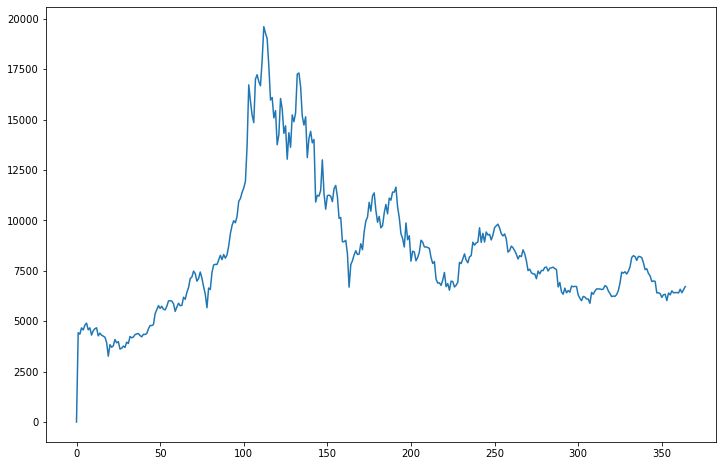

In [53]:
## 학습데이터 예측 결과

pd.Series(model_fit.predict()).plot(figsize=(12, 8))

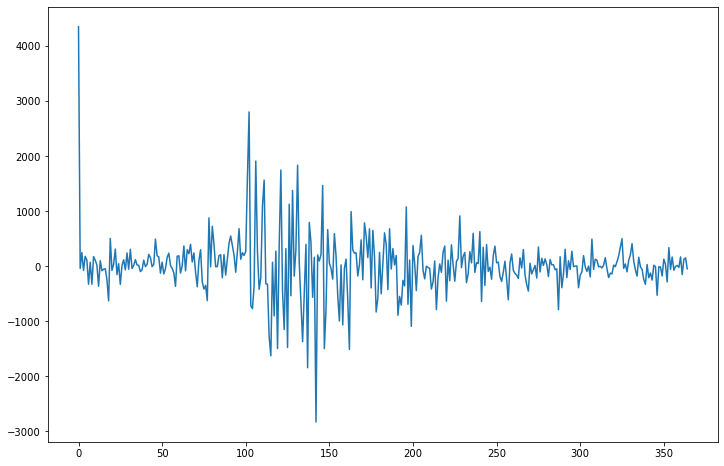

In [56]:
# 잔차 변동성 확인 - 정상성 X
plt.figure(figsize=(12, 8))
plt.plot(pd.Series(model_fit.resid))

## 실제 데이터와 비교

In [59]:
test_data

,2018-08-27 00:00:00,6719.266153846153
0,2018-08-28 00:00:00,7000.040000
1,2018-08-29 00:00:00,7054.276429
2,2018-08-30 00:00:00,6932.662500
3,2018-08-31 00:00:00,6981.946154


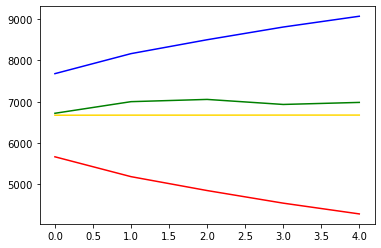

In [72]:
forecast_data= model_fit.get_forecast(steps=5).summary_frame()

test_file = './data/market-price-test.csv'
test_data = pd.read_csv(test_file, names=['day', 'y'])

pred_y = forecast_data['mean'].tolist()
test_y = test_data.y.values

pred_y_lower = forecast_data['mean_ci_lower'].tolist()
pred_y_upper = forecast_data['mean_ci_upper'].tolist()
    
plt.plot(pred_y, color='gold', )
plt.plot(pred_y_lower, color='red')
plt.plot(pred_y_upper, color='blue')
plt.plot(test_y, color='green')
plt.show()

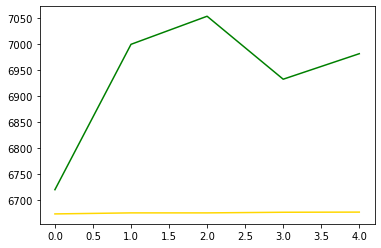

In [73]:
plt.plot(pred_y, color='gold')
plt.plot(test_y, color='green')

# Prophet 활용

In [84]:
from prophet import Prophet

data = pd.read_csv(paths, names=['ds', 'y'])


prophet = Prophet(seasonality_mode='multiplicative',
                 yearly_seasonality=True,
                 weekly_seasonality=True,
                 daily_seasonality=True,
                 changepoint_prior_scale=0.5)
prophet.fit(data)

/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [85]:
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)

forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,yhat,yhat_lower,yhat_upper
365,2018-08-27,6989.092566,6334.182346,7609.724656
366,2018-08-28,7100.829613,6380.562033,7758.982100
367,2018-08-29,7146.477986,6395.812255,7867.305596
368,2018-08-30,7244.457686,6519.430011,8010.769585
369,2018-08-31,7337.371987,6519.527814,8098.669164


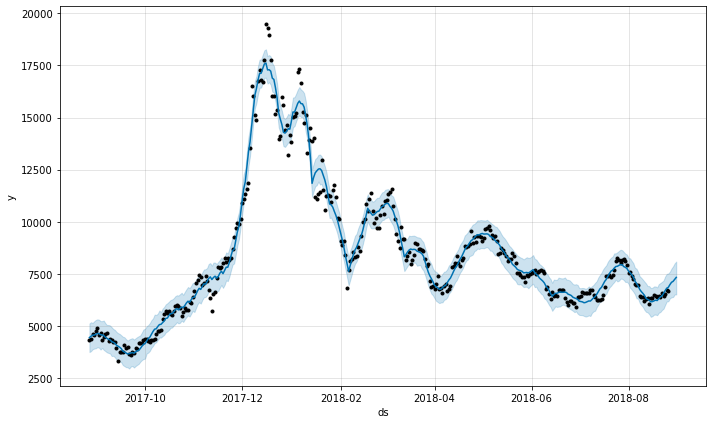

In [86]:
fig1 = prophet.plot(forecast_data)

/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


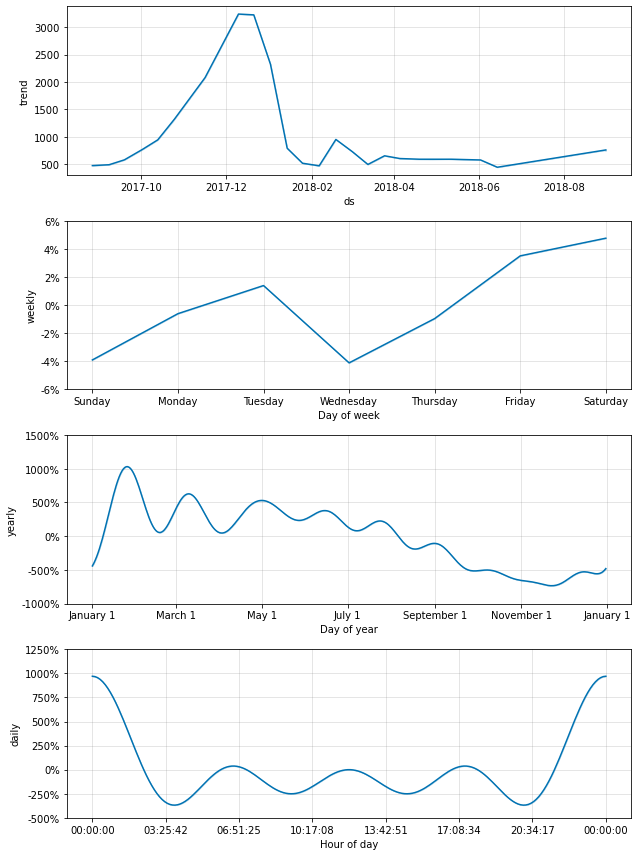

In [87]:
fig2 = prophet.plot_components(forecast_data) ## 트렌드 확인

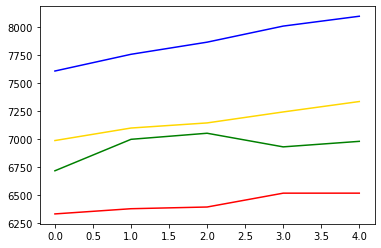

In [88]:
test_df = pd.read_csv(test_file, names=['ds', 'y'])

pred_y = forecast_data.yhat.values[-5:]
test_y = test_df.y.values

pred_y_lower = forecast_data['yhat_lower'].values[-5:]
pred_y_upper = forecast_data['yhat_upper'].values[-5:]


plt.plot(pred_y, color='gold', )
plt.plot(pred_y_lower, color='red')
plt.plot(pred_y_upper, color='blue')
plt.plot(test_y, color='green')
plt.show()

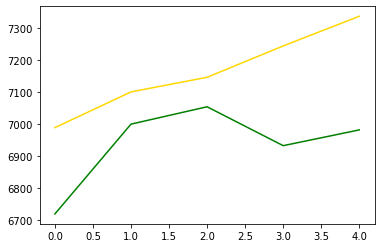

In [89]:
plt.plot(pred_y, color='gold')
plt.plot(test_y, color='green')

In [90]:
import math
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(pred_y, test_y))
rmse

251.0018833349742

## 예측력 향상시키는 방법
### 1. 상한값 혹은 하한값을 지정해 주는 것

/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


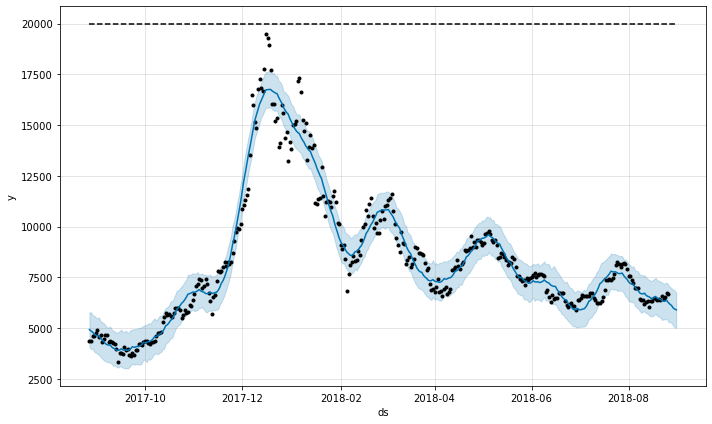

In [93]:
data = pd.read_csv(paths, names=['ds', 'y'])

# 상한가 지정
data['cap'] = 20000

prophet = Prophet(seasonality_mode='multiplicative',
                growth = 'logistic',
                yearly_seasonality=True,
                weekly_seasonality=True,
                daily_seasonality=True,
                changepoint_prior_scale=0.5)
prophet.fit(data)

# 5일치 예측

future_data = prophet.make_future_dataframe(periods=5, freq='d')

# 상한가 설정
future_data['cap'] = 20000
forecast_data = prophet.predict(future_data)

fig = prophet.plot(forecast_data)

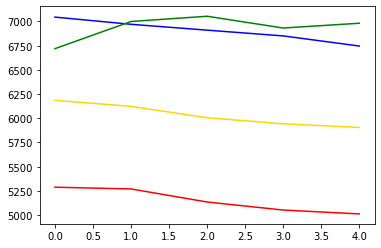

In [94]:
test_df = pd.read_csv(test_file, names=['ds', 'y'])

pred_y = forecast_data.yhat.values[-5:]
test_y = test_df.y.values

pred_y_lower = forecast_data['yhat_lower'].values[-5:]
pred_y_upper = forecast_data['yhat_upper'].values[-5:]


plt.plot(pred_y, color='gold', )
plt.plot(pred_y_lower, color='red')
plt.plot(pred_y_upper, color='blue')
plt.plot(test_y, color='green')
plt.show()

    -모델이 예측한 상하가(파란색)보다 실제 가격(녹색)이 더 높음. 말도 안됨

### 이상치 제거 

/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:n_changepoints greater than number of observations. Using 1.
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


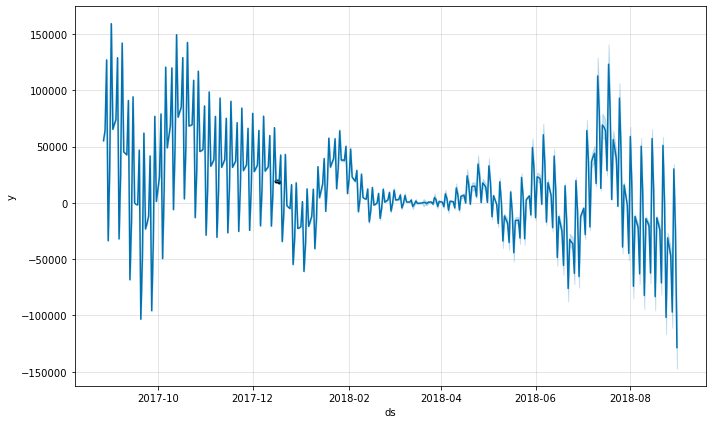

In [98]:
# 18,000 이상의 데이터를 이상치라고 판단
data = pd.read_csv(paths, names=['ds', 'y'])
data.loc[data['y'] < 18000, 'y'] = None

prophet = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=True,
                weekly_seasonality=True,
                daily_seasonality=True,
                changepoint_prior_scale=0.5)
prophet.fit(data)

# 5일치 예측

future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)

fig = prophet.plot(forecast_data)